<a href="https://colab.research.google.com/github/hrootscraft/customer-segmentation/blob/main/_3_KPrototypes_Clustering_BankCustomerSegmentationForMarketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KMeans is calculated using the Euclidian distance which is only suitable for numerical data.
While KMode is only suitable for categorical data, not mixed data types.
Enter KPrototypes for mixed type of data with both categorical and numerical features.

## Setup Dependencies

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d prakharrathi25/banking-dataset-marketing-targets

  0% 0.00/576k [00:00<?, ?B/s]
100% 576k/576k [00:00<00:00, 118MB/s]


In [ ]:
!unzip banking-dataset-marketing-targets.zip

Archive:  banking-dataset-marketing-targets.zip
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!pip3 install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.2-py3-none-any.whl size=190292 sha256=29f62e2fb97d8af9c28804a2c3ce7f198c4da2831247b38d3d6d9bd3bbeb9e9e
  Stored in directory: /root/.cache/pip/wheels/81/1b/61/aa85b78c3c0c8871f4231e3f4a03bb23cecb7db829498380ee
Successfully built pyod


## Quick Processing

- Without repeating the exlanatory steps from 1st or 2nd notebook, let's have the data a pandas dataframe. This dataset that we'll use to train the KPrototypes, will not have outliers and will have numerical features scaled normalized.

In [ ]:
import pandas as pd
import numpy as np

required_df = pd.read_csv("train.csv",sep=";").iloc[:,0:8]

In [ ]:
required_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan'],
      dtype='object')

In [ ]:
cat_cols = required_df.select_dtypes(include=['object']).columns
num_cols = required_df.select_dtypes(include=['int64']).columns

In [ ]:
# preprocess for removing the outliers because PYOD does not accept categorical features:
# 1. encode catergorical data
# 2. make the numerical columns have a Gaussian Distribution
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
# Suppress FutureWarnings from sklearn
warnings.simplefilter(action='ignore', category=FutureWarning)

ohe = Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False))])
ordinal_encode = Pipeline(steps=[("encoder", OrdinalEncoder())])
gauss_transform = Pipeline(steps=[("encoder", PowerTransformer())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_onehot', ohe, [value for value in cat_cols if value != 'education']),
        ('cat_ordinal', ordinal_encode, ["education"]),
        ('num_gauss', gauss_transform, num_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])
transformed_data = pipeline.fit_transform(required_df) # numpy.ndarray

# Access the preprocessor from the pipeline and get feature names
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

new_df = pd.DataFrame(transformed_data, columns = feature_names.tolist())

In [ ]:
new_df

cat_onehot__job_blue-collar  cat_onehot__job_entrepreneur  \
0                              0.0                           0.0   
1                              0.0                           0.0   
2                              0.0                           1.0   
3                              1.0                           0.0   
4                              0.0                           0.0   
...                            ...                           ...   
45206                          0.0                           0.0   
45207                          0.0                           0.0   
45208                          0.0                           0.0   
45209                          1.0                           0.0   
45210                          0.0                           1.0   

       cat_onehot__job_housemaid  cat_onehot__job_management  \
0                            0.0                         1.0   
1                            0.0                         0.0   
2                            0.0                         0.0   
3                            0.0                         0.0   
4                            0.0                         0.0   
...                          ...                         ...   
45206                        0.0                         0.0   
45207                        0.0                         0.0   
45208                        0.0                         0.0   
45209                        0.0                         0.0   
45210                        0.0                         0.0   

       cat_onehot__job_retired  cat_onehot__job_self-employed  \
0                          0.0                            0.0   
1                          0.0                            0.0   
2                          0.0                            0.0   
3                          0.0                            0.0   
4                          0.0                            0.0   
...                        ...                            ...   
45206                      0.0                            0.0   
45207                      1.0                            0.0   
45208                      1.0                            0.0   
45209                      0.0                            0.0   
45210                      0.0                            0.0   

       cat_onehot__job_services  cat_onehot__job_student  \
0                           0.0                      0.0   
1                           0.0                      0.0   
2                           0.0                      0.0   
3                           0.0                      0.0   
4                           0.0                      0.0   
...                         ...                      ...   
45206                       0.0                      0.0   
45207                       0.0                      0.0   
45208                       0.0                      0.0   
45209                       0.0                      0.0   
45210                       0.0                      0.0   

       cat_onehot__job_technician  cat_onehot__job_unemployed  \
0                             0.0                         0.0   
1                             1.0                         0.0   
2                             0.0                         0.0   
3                             0.0                         0.0   
4                             0.0                         0.0   
...                           ...                         ...   
45206                         1.0                         0.0   
45207                         0.0                         0.0   
45208                         0.0                         0.0   
45209                         0.0                         0.0   
45210                         0.0                         0.0   

       cat_onehot__job_unknown  cat_onehot__marital_married  \
0                          0.0                          1.0   
1           

In [ ]:
# 3. remove outliers from the original required df
# with categorical data and scaled numerical data
from pyod.models.ecod import ECOD

clf = ECOD()
clf.fit(new_df)
outliers = clf.predict(new_df)

new_df["outliers"] = outliers

In [ ]:
required_df

age           job   marital  education default  balance housing loan
0       58    management   married   tertiary      no     2143     yes   no
1       44    technician    single  secondary      no       29     yes   no
2       33  entrepreneur   married  secondary      no        2     yes  yes
3       47   blue-collar   married    unknown      no     1506     yes   no
4       33       unknown    single    unknown      no        1      no   no
...    ...           ...       ...        ...     ...      ...     ...  ...
45206   51    technician   married   tertiary      no      825      no   no
45207   71       retired  divorced    primary      no     1729      no   no
45208   72       retired   married  secondary      no     5715      no   no
45209   57   blue-collar   married  secondary      no      668      no   no
45210   37  entrepreneur   married  secondary      no     2971      no   no

[45211 rows x 8 columns]

In [ ]:
required_df["outliers"] = outliers # add a column of outliers to the required dataset
required_df_wo_outliers = required_df[required_df.outliers==0] # filter out the columns in the required dataset that are not outliers
required_df_wo_outliers = required_df_wo_outliers.drop(["outliers"], axis=1) # drop the outliers column from this required dataset

In [ ]:
pipe = Pipeline([('scaler', PowerTransformer())])
temp_df = pd.DataFrame(pipe.fit_transform(required_df_wo_outliers[["age","balance"]]), columns=["age","balance"])
temp_df

age   balance
0      1.638842  0.614693
1      0.483486 -0.518179
2     -0.776686 -0.548574
3      0.764207  0.322509
4     -0.514212 -0.363644
...         ...       ...
40685 -0.643216 -0.164381
40686 -2.047573 -0.194276
40687  1.107595 -0.017392
40688  1.567683 -0.102204
40689 -0.268556  0.971569

[40690 rows x 2 columns]

In [ ]:
required_df_wo_outliers_norm = required_df_wo_outliers.copy()
# Replace age and balance columns by preprocessed values
required_df_wo_outliers_norm = required_df_wo_outliers_norm.drop(["age", "balance"], axis = 1)
required_df_wo_outliers_norm["age"] = temp_df["age"].values
required_df_wo_outliers_norm["balance"] = temp_df["balance"].values
required_df_wo_outliers_norm

job  marital  education default housing loan       age  \
0        management  married   tertiary      no     yes   no  1.638842   
1        technician   single  secondary      no     yes   no  0.483486   
2      entrepreneur  married  secondary      no     yes  yes -0.776686   
3       blue-collar  married    unknown      no     yes   no  0.764207   
5        management  married   tertiary      no     yes   no -0.514212   
...             ...      ...        ...     ...     ...  ...       ...   
45202        admin.   single  secondary      no      no   no -0.643216   
45205    technician   single  secondary      no      no  yes -2.047573   
45206    technician  married   tertiary      no      no   no  1.107595   
45209   blue-collar  married  secondary      no      no   no  1.567683   
45210  entrepreneur  married  secondary      no      no   no -0.268556   

        balance  
0      0.614693  
1     -0.518179  
2     -0.548574  
3      0.322509  
5     -0.363644  
...         ...  
45202 -0.164381  
45205 -0.194276  
45206 -0.017392  
45209 -0.102204  
45210  0.971569  

[40690 rows x 8 columns]

In [ ]:
required_df_wo_outliers

age           job  marital  education default  balance housing loan
0       58    management  married   tertiary      no     2143     yes   no
1       44    technician   single  secondary      no       29     yes   no
2       33  entrepreneur  married  secondary      no        2     yes  yes
3       47   blue-collar  married    unknown      no     1506     yes   no
5       35    management  married   tertiary      no      231     yes   no
...    ...           ...      ...        ...     ...      ...     ...  ...
45202   34        admin.   single  secondary      no      557      no   no
45205   25    technician   single  secondary      no      505      no  yes
45206   51    technician  married   tertiary      no      825      no   no
45209   57   blue-collar  married  secondary      no      668      no   no
45210   37  entrepreneur  married  secondary      no     2971      no   no

[40690 rows x 8 columns]

## KPrototypes

### Decide K

In [ ]:
!pip3 install kmodes

- Here, we are finding the K for KPrototypes using unscaled data because the concept of distance, which is a key factor in clustering algorithms, can be affected by the scale of the features. If you use the dataset with scaled features, the results may be influenced by the scaling transformation, and the optimal K value may not accurately reflect the structure of the original data. But, when we train the KPrototypes Clustering algorithm, we use the scaled features because better convergence and a more balanced influence of each feature during the clustering process.
- Also, when we employ Elbow Method because with

In [ ]:
# ## snippet takes a few hrs to complete
# from kmodes.kprototypes import KPrototypes

# # categorical_columns_index contains the indices of categorical columns
# categorical_columns_index = [required_df_wo_outliers.columns.get_loc(col) for col in cat_cols]

# # Elbow Method to find optimal k : we use
# cost = []
# range_ = range(2, 15)
# for cluster in range_:
#     kproto = KPrototypes(n_jobs=-1, n_clusters=cluster, init='Huang', random_state=0)
#     kproto.fit_predict(required_df_wo_outliers, categorical=categorical_columns_index)
#     cost.append(kproto.cost_)
#     print('Cluster initiation: {}'.format(cluster))

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_theme()
# %matplotlib inline

# # Converting the results into a dataframe
# df_cost = pd.DataFrame({'Cluster': range_, 'Cost': cost})

# plt.figure(figsize=(8, 4.8))
# sns.set(style="whitegrid")
# sns.lineplot(x='Cluster', y='Cost', data=df_cost, marker='o')
# sns.scatterplot(x='Cluster', y='Cost', data=df_cost)
# sns.pointplot(x='Cluster', y='Cost', data=df_cost, markers="D", linestyles='--', color='r')
# plt.title('Optimal number of clusters with Elbow Method')
# plt.xlabel('Number of Clusters k')
# plt.ylabel('Cost')
# plt.show()

- We select k=5 which is even corroborated by KMeans.

### Model

In [ ]:
required_df_wo_outliers

age           job  marital  education default  balance housing loan
0       58    management  married   tertiary      no     2143     yes   no
1       44    technician   single  secondary      no       29     yes   no
2       33  entrepreneur  married  secondary      no        2     yes  yes
3       47   blue-collar  married    unknown      no     1506     yes   no
5       35    management  married   tertiary      no      231     yes   no
...    ...           ...      ...        ...     ...      ...     ...  ...
45202   34        admin.   single  secondary      no      557      no   no
45205   25    technician   single  secondary      no      505      no  yes
45206   51    technician  married   tertiary      no      825      no   no
45209   57   blue-collar  married  secondary      no      668      no   no
45210   37  entrepreneur  married  secondary      no     2971      no   no

[40690 rows x 8 columns]

In [ ]:
from kmodes.kprototypes import KPrototypes
categorical_columns_index = [required_df_wo_outliers_norm.columns.get_loc(col) for col in cat_cols]

kprototype = KPrototypes(n_jobs = -1, n_clusters = 5, init = 'Huang', random_state = 0)
kprototype.fit(required_df_wo_outliers_norm, categorical = categorical_columns_index)

predicted_cluster_labels = kprototype.predict(required_df_wo_outliers_norm , categorical = categorical_columns_index)
predicted_cluster_labels

array([3, 0, 0, ..., 3, 3, 0], dtype=uint16)

In [ ]:
print("Cluster Centroids\n", kprototype.cluster_centroids_, "\n")
print("# of Iterations:", kprototype.n_iter_, "\n")
print("Cost:", kprototype.cost_, "\n")

Cluster Centroids
 [['-0.07915368411931316' '-0.17156791779628477' 'blue-collar' 'married'
  'secondary' 'no' 'yes' 'no']
 ['-0.01266718230230479' '-2.5453310903092787' 'blue-collar' 'married'
  'secondary' 'no' 'yes' 'no']
 ['-1.149035572227314' '-0.14754016441930362' 'management' 'single'
  'secondary' 'no' 'yes' 'no']
 ['1.1678730209237789' '-0.052112415602359255' 'management' 'married'
  'secondary' 'no' 'no' 'no']
 ['0.17112008166557618' '2.354295487265074' 'management' 'married'
  'secondary' 'no' 'yes' 'no']] 

# of Iterations: 65 

Cost: 63888.60598938271 



## Evaluation

### with Visualization

Now that we have our predictions, we visualize the results for further analysis. PCA method and t-SNE do not admit categorical variables so we use the library prince for its MCA (Multiple Correspondence Analysis) method which does accept a mixed dataset.  

In [ ]:
!pip3 install prince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 5.6 MB/s eta 0:00:00


In [ ]:
from prince import MCA

def get_MCA_2d(df, predict):
    mca = MCA(n_components=2, n_iter=100, random_state=101, engine='sklearn')
    mca_2d_df = mca.fit_transform(df)
    mca_2d_df.columns = ["Component_1", "Component_2"]
    mca_2d_df["cluster"] = predict
    return mca, mca_2d_df

In [ ]:
def get_MCA_3d(df, predict):
    mca = MCA(n_components=3, n_iter=100, random_state=101, engine='sklearn')
    mca_3d_df = mca.fit_transform(df)
    mca_3d_df.columns = ["Component_1", "Component_2", "Component_3"]
    mca_3d_df["cluster"] = predict
    return mca, mca_3d_df

In [ ]:
import plotly.express as px

def plot_pca_2d(df, opacity=0.8, width_line = 0.1):
    # convert the datatype of cluster labels to object so as to get considered as a categorical column
    df = df.astype({"cluster": "object"})
    # df = df.sort_values("cluster")
    fig = px.scatter(df, x="Component_1", y="Component_2", color='cluster', template="plotly", color_discrete_sequence=px.colors.qualitative.Pastel)\
    .update_traces(marker={"size": 8, "opacity": opacity,"line":{"width": width_line, "color": "black"}})\
    .update_layout(width = 800, height = 800, autosize = True, showlegend = True,scene = dict(xaxis=dict(title = 'Component_1'), yaxis=dict(title = 'Component_2')))
    fig.show()

In [ ]:
def plot_pca_3d(df, opacity=0.8, width_line = 0.1):
    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")
    fig = px.scatter_3d(df, x='Component_1', y='Component_2', z='Component_3', color='cluster', template="plotly", color_discrete_sequence=px.colors.qualitative.Pastel)\
    .update_traces(marker={"size": 4, "opacity": opacity, "line": {"width": width_line,"color": "black"}})\
    .update_layout(width = 800, height = 800, autosize = True,
                   showlegend = True, scene = dict(xaxis=dict(title = 'Component_1'),
                                                   yaxis=dict(title = 'Component_2'),
                                                   zaxis=dict(title = 'Component_3')))
    fig.show()

In [ ]:
mca_2d_obj, mca_2d_df = get_MCA_2d(required_df_wo_outliers_norm, predicted_cluster_labels)

In [ ]:
mca_2d_obj.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.270         0.03%                      0.03%
1              0.255         0.03%                      0.07%

In [ ]:
plot_pca_2d(mca_2d_df, opacity=1, width_line=0.5)

In [ ]:
mca_3d_obj, mca_3d_df = get_MCA_3d(required_df_wo_outliers_norm, predicted_cluster_labels)

In [ ]:
mca_3d_df

Component_1  Component_2  Component_3  cluster
0         0.662535     0.987567    -0.180520        3
1         0.103642    -0.333205     0.125617        0
2        -0.165308    -0.259992    -0.057749        0
3        -0.548013     0.209738    -0.804611        0
5         0.584402     0.186712    -0.425422        0
...            ...          ...          ...      ...
45202     0.177391    -0.402490     0.316896        2
45205     0.151542    -0.535868     0.551481        2
45206     0.346016     0.277968    -0.156025        3
45209    -0.520099     0.426750     0.042538        3
45210    -0.109002     0.212858    -0.098457        0

[40690 rows x 4 columns]

In [ ]:
mca_3d_obj.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.270         0.03%                      0.03%
1              0.255         0.03%                      0.07%
2              0.226         0.03%                      0.09%

- The cumulative frequency of the 3 components is only 0.09%
- It's on our data that we have captured basically 0% variability of the original data.
- Basically we cannot draw any conclusions from the clustering.

Let's look at the plot which surely would show overlapping clusters.

In [ ]:
plot_pca_3d(mca_3d_df, opacity=1, width_line=0.1)

- It does not look good at all. Cannot differentiate the clusters.
- There's one thing we can do to visualize our model's performance as a last resort. Use the dataset with appropriate transformations and then feed it to PCA to chunk out the principal components. Let's get to it.

In [ ]:
import prince

def get_pca_3d(df, predict):
    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )
    pca_3d_object.fit(df)
    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["PC1", "PC2", "PC3"]
    df_pca_3d["cluster"] = predict
    return pca_3d_object, df_pca_3d


def plot_pca_3d(df, opacity=0.8, width_line = 0.1):
    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")
    fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='cluster', template="plotly", color_discrete_sequence=px.colors.qualitative.Pastel)\
    .update_traces(marker={"size": 4, "opacity": opacity, "line": {"width": width_line,"color": "black"}})\
    .update_layout(width = 800, height = 800, autosize = True,
                   showlegend = True, scene = dict(xaxis=dict(title = 'PC1'),
                                                   yaxis=dict(title = 'PC2'),
                                                   zaxis=dict(title = 'PC3')))
    fig.show()

In [ ]:
new_df = new_df[new_df.outliers == 0]

In [ ]:
pca_3d_object, df_pca_3d = get_pca_3d(new_df, predicted_cluster_labels)
plot_pca_3d(df_pca_3d, opacity=1, width_line = 0.1)

In [ ]:
pca_3d_object.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0              2.244        11.81%                     11.81%
1              1.772         9.33%                     21.14%
2              1.243         6.54%                     27.68%

- It does not look bad, in fact it has a certain resemblance to what has been obtained in KMeans.
- We have the same cumulative variance captured as in KMeans.

In [ ]:
def get_pca_2d(df, predicted_labels):
    pca_2d_obj = prince.PCA(
      n_components=2,
      n_iter=3,
      rescale_with_mean=True,
      rescale_with_std=True,
      copy=True,
      check_input=True,
      engine='sklearn',
      random_state=42
    )
    pca_2d_obj.fit(df)
    df_pca_2d = pca_2d_obj.transform(df)
    df_pca_2d.columns = ["PC1", "PC2"]
    df_pca_2d["cluster"] = predicted_labels
    return pca_2d_obj, df_pca_2d

def plot_pca_2d(df, opacity=0.8, width_line = 0.1):
    # convert the datatype of cluster labels to object so as to get considered as a categorical column
    df = df.astype({"cluster": "object"})
    # df = df.sort_values("cluster")
    fig = px.scatter(df, x="PC1", y="PC2", color='cluster', template="plotly", color_discrete_sequence=px.colors.qualitative.Pastel)\
    .update_traces(marker={"size": 8, "opacity": opacity,"line":{"width": width_line, "color": "black"}})\
    .update_layout(width = 800, height = 800, autosize = True, showlegend = True,scene = dict(xaxis=dict(title = 'PC1'), yaxis=dict(title = 'PC2')))
    fig.show()

In [ ]:
pca_2d_object, df_pca_2d = get_pca_2d(new_df, predicted_cluster_labels)
plot_pca_2d(df_pca_2d, opacity=1, width_line = 0.5)

### with Classification

In [ ]:
required_df_wo_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40690 entries, 0 to 45210
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40690 non-null  int64 
 1   job        40690 non-null  object
 2   marital    40690 non-null  object
 3   education  40690 non-null  object
 4   default    40690 non-null  object
 5   balance    40690 non-null  int64 
 6   housing    40690 non-null  object
 7   loan       40690 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.8+ MB


In [ ]:
import lightgbm as lgb

for col in cat_cols:
    required_df_wo_outliers[col] = required_df_wo_outliers[col].astype('category')

In [ ]:
lgbm_clf_for_kproto = lgb.LGBMClassifier(colsample_bytree=0.8)
lgbm_clf_for_kproto.fit(X=required_df_wo_outliers,
                    y=predicted_cluster_labels,
                    feature_name="auto",
                    categorical_feature="auto")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 40690, number of used features: 8
[LightGBM] [Info] Start training from score -1.096060
[LightGBM] [Info] Start training from score -3.509594
[LightGBM] [Info] Start training from score -1.292840
[LightGBM] [Info] Start training from score -1.268342
[LightGBM] [Info] Start training from score -2.524255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMClassifier(colsample_bytree=0.8)

In [ ]:
from sklearn.model_selection import cross_val_score

# scoring metric is f1 weighted because among the 5 clusters our KMeans model found one of them
# was thin in size ergo safer side we take weighted f1 score to account for imbalanced classes
cv_scores_lgbm_clf_for_kproto = cross_val_score(lgbm_clf_for_kproto, required_df_wo_outliers, predicted_cluster_labels, scoring='f1_weighted')
print(f'CV F1 score for KMeans clusters is {np.mean(cv_scores_lgbm_clf_for_kproto)}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 32552, number of used features: 8
[LightGBM] [Info] Start training from score -1.096004
[LightGBM] [Info] Start training from score -3.509183
[LightGBM] [Info] Start training from score -1.292863
[LightGBM] [Info] Start training from score -1.268429
[LightGBM] [Info] Start training from score -2.524255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [ ]:
!pip3 install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.2 MB/s eta 0:00:00


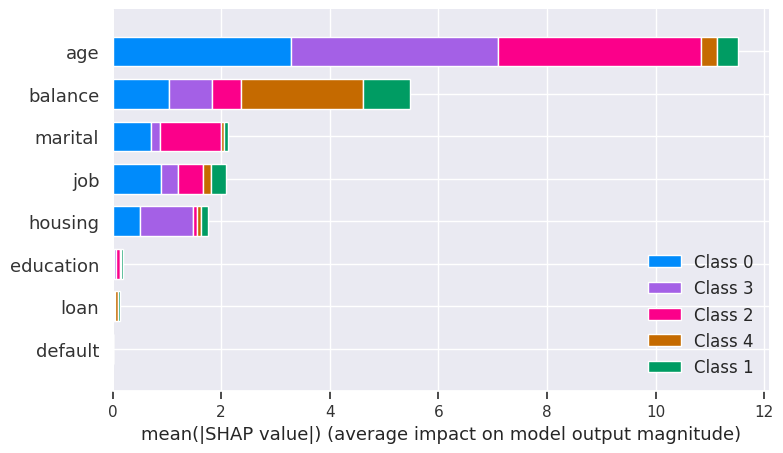

In [ ]:
import shap
km_explainer = shap.TreeExplainer(lgbm_clf_for_kproto)
km_shap_values = km_explainer.shap_values(required_df_wo_outliers)
shap.summary_plot(km_shap_values, required_df_wo_outliers, plot_type="bar")

Here, we get importance given to age and balance for distinction within clusters.

## Cluster Information

In [ ]:
required_df_wo_outliers["cluster"] = predicted_cluster_labels

cluster_summary = required_df_wo_outliers.groupby('cluster').agg(
    {
        'job': lambda x: x.value_counts().index[0],
        'marital': lambda x: x.value_counts().index[0],
        'education': lambda x: x.value_counts().index[0],
        'housing': lambda x: x.value_counts().index[0],
        'loan': lambda x: x.value_counts().index[0],
        'age':'mean',
        'balance': 'mean',
        'default': lambda x: x.value_counts().index[0],
    }
)

cluster_summary.sort_values("age").reset_index()

cluster          job  marital  education housing loan        age  \
0        2   management   single  secondary     yes   no  30.559853   
1        0  blue-collar  married  secondary     yes   no  38.867701   
2        1  blue-collar  married  secondary     yes   no  39.972062   
3        4   management  married  secondary     yes   no  41.843865   
4        3   management  married  secondary      no   no  52.053294   

       balance default  
0   696.464500      no  
1   645.477350      no  
2  -416.784717      no  
3  6680.252147      no  
4   873.506290      no

This wasn't as useful. Let's try another model Kmeans but with Sentence Embeddings.